In [1]:
%matplotlib inline
from pathlib import *
import numpy as np
import pandas as pd
import nibabel as nib
import mmimproc as ip
from mmimproc.io.mixed import df2h5
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

def append2fn(fn, newstr):
    """Appends new string to end of file name and before file extentions.
    """
    return Path(fn).stem + newstr + ''.join(Path(fn).suffixes)

ssvolnum = 10    # integer volume number where steady state is acheived 

# set up file naming
datadir = ip.fs_local   # enter pathlib or string for BIDS root data directory
proj = 'toddandclark'   # enter project name
subj = 'badrestingstate'  # enter subject name (todo: subject list option for for loop)
niiname = 'rest_50125.nii'  # name of raw resting nifti file to process (todo: for loop if needed)
resultsh5 = 'tcj_results1.h5'
namedict  = {'datadir': datadir, 'proj': proj, 'subj': subj, 'niiname': niiname,
             'maskname': append2fn(niiname, '_mask'), 'snrmaskname': append2fn(niiname, '_snrmask'),
            'resultsname': resultsh5}

# load resting state file memory map
badvol = nib.load('{datadir}/{proj}/{subj}/{niiname}'.format(**namedict))
# make the numpy data array
badvoldata = np.asanyarray(badvol.dataobj).astype(np.float64)[...,ssvolnum:]
# resave with non steady state vols chopped off
namedict['chopvolfname'] = append2fn(niiname, '_{0}vols'.format(badvoldata.shape[-1]))
chopvolfname = '{datadir}/{proj}/{subj}/{chopvolfname}'.format(**namedict)
nib.save(nib.Nifti1Image(badvoldata, badvol.affine), chopvolfname)

# make 3 part mask
bvsh = badvoldata.shape
badvolmask = np.zeros(bvsh).astype(np.int)
badvolmask[39:41 ,25:31 ,17:20, :] = 1  # Left operc
badvolmask[25:27 ,25:31 ,17:20, :] = 2  # Right operc
# define left anterior superior corner voxels for noise estimation
oobcoord = np.index_exp[bvsh[0] - 5:bvsh[0] - 1, bvsh[1] - 10:bvsh[1] - 1, bvsh[2] - 4:bvsh[2] - 1, :]
badvolmask[oobcoord] = 3 # out of body area left anterior superior corner
# save mask to nii file
maskfname = '{datadir}/{proj}/{subj}/{maskname}'.format(**namedict)
nib.save(nib.Nifti1Image(badvolmask, badvol.affine), maskfname)

In [2]:
# generate snr data for ROIs and save nii mask with stats embedded
mbadvoldata_roi1 = np.where(badvolmask == 1, badvoldata, np.nan)
mean_roi1 = np.nanmean(mbadvoldata_roi1, axis=(0, 1, 2))
std_roi1 = np.nanstd(mbadvoldata_roi1, axis=(0, 1, 2))
mbadvoldata_roi2 = np.where(badvolmask == 2, badvoldata, np.nan)
mean_roi2 = np.nanmean(mbadvoldata_roi2, axis=(0, 1, 2))
std_roi2 = np.nanstd(mbadvoldata_roi2, axis=(0, 1, 2))
mbadvoldata_roi3 = np.where(badvolmask == 3, badvoldata, np.nan)
mean_roi3 = np.nanmean(mbadvoldata_roi3, axis=(0, 1, 2))
std_roi3 = np.nanstd(mbadvoldata_roi3, axis=(0, 1, 2))
snr1 = mean_roi1 / std_roi3
snr2 = mean_roi2 / std_roi3
snr1a = mean_roi1 / std_roi1
snr2a = mean_roi2 / std_roi2
snrmask = np.zeros(bvsh).astype(np.float64)
snrmask[39:41 ,25:28 ,17:20, :] = snr1  # Left operc snr mean roi1 / std deviation out of body
snrmask[25:27 ,25:28 ,17:20, :] = snr2  # Right operc snr mean roi2 / std deviation out of body
snrmask[39:41 ,28:31 ,17:20, :] = snr1a  # Left operc snr mean roi1 / std dev roi1
snrmask[25:27 ,28:31 ,17:20, :] = snr2a  # Right operc snr mean roi2 / std dev roi2
snrmask[oobcoord] = std_roi3            # out of body sigma left anterior superior corner
snrmaskfname = '{datadir}/{proj}/{subj}/{snrmaskname}'.format(**namedict)
nib.save(nib.Nifti1Image(snrmask, badvol.affine), snrmaskfname)
# todo: save as dataframe to h5 file
results_df = pd.DataFrame()

<Figure size 720x1152 with 0 Axes>

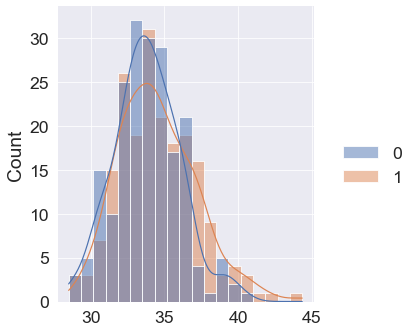

In [3]:
plt.figure(figsize=(10,16))
sns.set_context('paper', font_scale=2)
#sns.legend(['SNR ROI 1', 'SNR ROI 2'])
sns.displot(data=[snr1a, snr2a], kde=True, label=['SNR ROI 1', 'SNR ROI 2'])


In [9]:
toddfile = '/Users/mrjeffs/projects/toddandclark/results/scannerbadness_test_october14_2020.csv'
todd_results = pd.read_csv(toddfile)
todd_results.head(10)

,subid,raw2,raw3,niak2,niak3,motion
0,51456,0,0,0,0,0.295384
1,51458,4,3,4,0,0.147430
2,51459,0,0,0,0,0.107184
3,51460,0,0,0,0,0.122920
4,51462,3,1,0,0,0.464329
5,51464,0,0,0,0,0.229093
6,51465,0,0,0,0,0.108433
7,51466,0,0,1,0,0.245712
8,51467,0,0,0,0,0.193433
9,51469,2,0,1,0,0.214401


In [23]:
datadir

PosixPath('/Users/mrjeffs/data')